<img alt='UCL' src="images/ucl_logo.png" align='center'>


[<img src="images/noun_post_2109127.svg" width="50" align='right'>](016_Python_for.ipynb)
[<img src="images/noun_pre_2109128.svg" width="50" align='right'>](018_Python_xxx.ipynb)



# 028 GDAL: time series

### Purpose


In this section, we'll continue to look at the MODIS LAI, with a view to forming a time series dataset. AT the end of this session, you will be able to generate a 3D numpy array of some MODIS geophysical variable for a selcted area and time.


### Prerequisites

You will need some understanding of the following:


* [001 Using Notebooks](001_Notebook_use.ipynb)
* [010 Variables, comments and print()](010_Python_Introduction.ipynb)
* [011 Data types](011_Python_data_types.ipynb) 
* [012 String formatting](012_Python_strings.ipynb)
* [013_Python_string_methods](013_Python_string_methods.ipynb)
* [020_Python_files](020_Python_files.ipynb)
* [021 Streams](021_Streams.ipynb)
* [022 Read write files](022_Read_write_files.ipynb)
* [023 Plotting](023_Plotting.ipynb)
* [024 Image display](024_Image_display.ipynb)
* [025 NASA MODIS Earthdata](025_NASA_MODIS_Earthdata.ipynb)
* [026_Numpy](026_Numpy.ipynb)
* [027_GDAL_mosaicing_and_masking](027_GDAL_mosaicing_and_masking.ipynb)

You must make sure you can recall the details of the work covered in [027_GDAL_mosaicing_and_masking](027_GDAL_mosaicing_and_masking.ipynb).

### Test

You should run a [NASA account test](notebooks/004_Accounts.ipynb#Test) if you have not already done so.


Use Modis.get_modis to plot the LAI for France for doy 49, 2019

This is mostly a copy from the code in the notes. But again we need
to check the tiles to use. We can find that this should be 
['h17v03','h17v04','h18v03','h18v04']

We also need to change the doy from 41 to 49 !!!

We also need to look up the FIPS code for France, since this 
is not given. This can be found to be "FIPS='FR'" from a quick 
search.



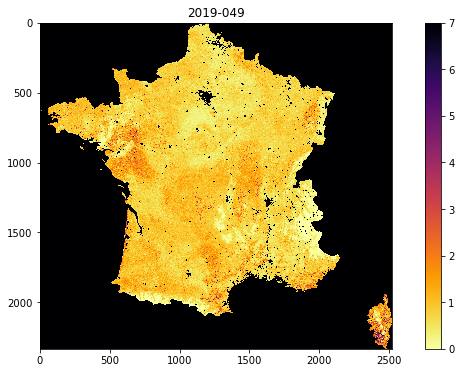

In [27]:
import gdal
from geog0111.modis import Modis
import matplotlib.pyplot as plt

msg = '''
Use Modis.get_modis to plot the LAI for France for doy 49, 2019

This is mostly a copy from the code in the notes. But again we need
to check the tiles to use. We can find that this should be 
['h17v03','h17v04','h18v03','h18v04']

We also need to change the doy from 41 to 49 !!!

We also need to look up the FIPS code for France, since this 
is not given. This can be found to be "FIPS='FR'" from a quick 
search.
'''

kwargs = {
    'tile'      :    ['h17v03','h17v04','h18v03','h18v04'],
    'product'   :    'MCD15A3H',
    'sds'       :    'Lai_500m',
}
doy = 49
year = 2019

modis = Modis(**kwargs)

warp_args = {
    'dstNodata'     : 255,
    'format'        : 'MEM',
    'cropToCutline' : True,
    'cutlineWhere'  : "FIPS='FR'",
    'cutlineDSName' : 'data/TM_WORLD_BORDERS-0.3.shp'
}

# getting the dataset is this simple
mfiles = modis.get_modis(year,doy,warp_args=warp_args)

# This is just plotting 
g = gdal.Open(mfiles['Lai_500m'])
fig, axs = plt.subplots(1,1,figsize=(12,6))
im = axs.imshow(g.ReadAsArray()*0.1,vmax=7,\
                cmap=plt.cm.inferno_r,interpolation='nearest')
axs.set_title(mfiles['bandnames'][0])
fig.colorbar(im, ax=axs)

print(msg)

In [25]:

msg = '''
find the median LAI for France for doy 46, 2019 to 2 d.p.

Same as exercise 3, but motice median is asked for

For this part, we need to build a mask of valid data points
Then find the mean LAI over that set.
'''
print(msg)

# dataset scaled
lai = g.ReadAsArray()*0.1

# mask for valid
mask = (lai <= 10.0)

# np.median
mean_lai = np.median(lai[mask])

# mean
print(f'Mean LAI for LU for doy {doy} {year} is {mean_lai :.2f}')


find the median LAI for France for doy 46, 2019 to 2 d.p.

Same as exercise 3, but motice median is asked for

For this part, we need to build a mask of valid data points
Then find the mean LAI over that set.

Mean LAI for LU for doy 49 2019 is 0.80


## Timeseries

We can conveniently generate a timeseries dataset using the `gdal` VRT file approach we used in [027_GDAL_mosaicing_and_masking](027_GDAL_mosaicing_and_masking.ipynb). 

In this case, the main process would be:

    - initialise band name list bnames
    - initialise list sds_set
    - loop over some set of doy values:
        - retrieve an SDS for each doy
        - make a band name for the doy/year
        - stitch tiles together into one VRT
        - append the new SDS to the list sds_set
        - append the band name to the list bnames

In [3]:
import gdal
from geog0111.modis import Modis

kwargs = {
    'tile'      :    ['h17v03','h18v03'],
    'product'   :    'MCD15A3H',
    'sds'       :    'Lai_500m',
}
year = 2019
# list of doys we want
# - every 4 days for MCD15A3H
doys = [41,45,49]

modis = Modis(**kwargs)

# initialise list sds_set
sds_set = []
bnames = []

# loop over some set of doy values:
for doy in doys:
    # retrieve an SDS for each doy
    files,sds = modis.get_files(year,doy)
    # choose only the first SDS for now
    this_sds = sds[0]
    
    # make a band name for the doy/year
    bandname = f'{year}-{doy:0>3d}'
    
    # stitch tiles together into one VRT
    # called ofile
    ofile = f"work/stitch_{modis.product}.{doy}.vrt"
    stitch_vrt = gdal.BuildVRT(ofile,this_sds)

    # append the new SDS to the list sds_set
    sds_set.append(ofile)
    # append the band name to the list bnames
    bnames.append(bandname)

print(sds_set)
print(bnames)

['work/stitch_MCD15A3H.41.vrt', 'work/stitch_MCD15A3H.45.vrt', 'work/stitch_MCD15A3H.49.vrt']
['2019-041', '2019-045', '2019-049']


Now we have a set of SDS we want to put them into a VRT file to represent the time series. We do this as we have previously, specifying the outoput name `work/stitch_set.vrt` here, and ythe listr of SDS that goes in to the time series,`sds_set` here:

In [4]:
# build a VRT "work/stitch_set.vrt"
stitch_vrt = gdal.BuildVRT("work/stitch_set.vrt", sds_set,separate=True)

# test it by reading and plotting
g = gdal.Open("work/stitch_set.vrt")
data = g.ReadAsArray()
print(data.shape)

(3, 2400, 4800)


The dataset is now 3D. The first dimensions represent the time samples, so:

    data[0] -> bnames[0]
    
etc.

In [5]:
import numpy as np
for i in range(data.shape[0]):
    print(f'band {bnames[i]} -> mean {np.mean(data[i])}')

band 2019-041 -> mean 166.24298064236112
band 2019-045 -> mean 166.25176796875
band 2019-049 -> mean 165.74304947916667


Cut out the UK and visualise as before:

In [6]:
# subset and display

warp_args = {
    'dstNodata'     : 255,
    'format'        : 'MEM',
    'cropToCutline' : True,
    'cutlineWhere'  : "FIPS='UK'",
    'cutlineDSName' : 'data/TM_WORLD_BORDERS-0.3.shp'
}

g = gdal.Warp("", "work/stitch_set.vrt",**warp_args)
data = g.ReadAsArray()*0.1
print(data.shape)

(3, 2623, 1394)


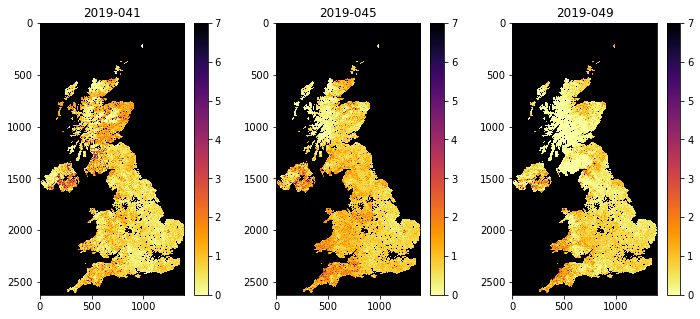

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3,figsize=(12,5))
axs = axs.flatten()
for i in range(data.shape[0]):
    im = axs[i].imshow(data[i],vmax=7,\
                cmap=plt.cm.inferno_r,interpolation='nearest')
    fig.colorbar(im, ax=axs[i])
    axs[i].set_title(bnames[i])

### `Modis.get_modis`

For convenience, we can again use the function `Modis.get_modis` to combine these, simply by passing a list of `doy` values, rather than a single `doy`.

In [9]:
import gdal
from geog0111.modis import Modis
import matplotlib.pyplot as plt

kwargs = {
    'tile'      :    ['h17v03','h18v03'],
    'product'   :    'MCD15A3H',
    'sds'       :    'Lai_500m',
}
year = 2019
# list of doys we want
doys = [41,45,49]

modis = Modis(**kwargs)

warp_args = {
    'dstNodata'     : 255,
    'format'        : 'MEM',
    'cropToCutline' : True,
    'cutlineWhere'  : "FIPS='UK'",
    'cutlineDSName' : 'data/TM_WORLD_BORDERS-0.3.shp'
}

mfiles = modis.get_modis(year,doys,warp_args=warp_args)
print(mfiles.keys())

dict_keys(['Lai_500m', 'bandnames'])


Now let's mask out invalid data points (`> 10.0` when scaled by 0.1), and display the results:

In [10]:
import numpy as np

g = gdal.Open(mfiles['Lai_500m'])

# dataset and band nanes
data = g.ReadAsArray()*0.1

# valid mask
data[data>10.0] = np.nan
bnames = mfiles['bandnames']
print(data.shape)

(3, 2623, 1394)


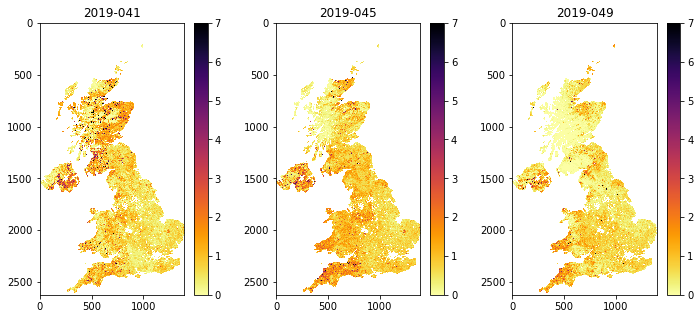

In [12]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3,figsize=(12,5))
axs = axs.flatten()
for i in range(data.shape[0]):
    im = axs[i].imshow(data[i],vmax=7,\
                cmap=plt.cm.inferno_r,interpolation='nearest')
    fig.colorbar(im, ax=axs[i])
    axs[i].set_title(bnames[i])

A convenient feature of `Modis.get_modis` is that we can use wildcards for specifying dates. 

So, to get a year of LAI data for the UK:


In [ ]:
import gdal
from geog0111.modis import Modis
import matplotlib.pyplot as plt

kwargs = {
    'verbose' : True,
    'tile'      :    ['h17v03','h18v03'],
    'product'   :    'MCD15A3H',
    'sds'       :    'Lai_500m',
}
year = 2019
# list of doys we want
doys = "*"

modis = Modis(**kwargs)

warp_args = {
    'dstNodata'     : 255,
    'format'        : 'MEM',
    'cropToCutline' : True,
    'cutlineWhere'  : "FIPS='UK'",
    'cutlineDSName' : 'data/TM_WORLD_BORDERS-0.3.shp'
}

mfiles = modis.get_modis(year,doys,warp_args=warp_args,step=4)
print(mfiles.keys())

In [ ]:
## single pixel in time


In [15]:
## by lat/lon

In [14]:
def world2Pixel(geoMatrix, x, y):
    """
    Uses a gdal geomatrix (gdal.GetGeoTransform()) to calculate
    the pixel location of a geospatial coordinate
    """
    ulX = geoMatrix[0]
    ulY = geoMatrix[3]
    xDist = geoMatrix[1]
    yDist = geoMatrix[5]
    rtnX = geoMatrix[2]
    rtnY = geoMatrix[4]
    pixel = np.round((x - ulX) / xDist).astype(np.int)
    line = np.round((ulY - y) / xDist).astype(np.int)
    return (pixel, line)

def 
raster = gdal.Open( reference_filename )
geo_t = raster.GetGeoTransform()

pnts = lat,lon

pixel, line = world2Pixel(geo_t,pnts[0],pnts[1])

## Summary

We now know how to
